In [1]:
import pandas as pd

In [2]:
file_path_pm10_average_location_wise = "C:/Users/shafi/Music/Spatial_Research_Coding_Post/HourlyAverage_Data/hourly_pm10_output_location_wise.xlsx"
data_3 = pd.read_excel(file_path_pm10_average_location_wise, sheet_name= 'data_3_Feb24')

#### k-means clustering
##### Visualisation

In [5]:
import pandas as pd
from sklearn.cluster import KMeans
import folium


valid_mask = data_3[['lat', 'lon', 'mean_location_pm10']].notna().all(axis=1) # missing values need to be masked

cluster_data = data_3.loc[valid_mask, ['lat', 'lon', 'mean_location_pm10']]

# K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)  # Explicitly set n_init to suppress warning
cluster_labels = kmeans.fit_predict(cluster_data)


data_3['cluster'] = -1  # Use -1 to indicate rows with missing values

data_3.loc[valid_mask, 'cluster'] = cluster_labels

# base map centered on MMR
cluster_map = folium.Map(location=[19.0760, 72.8777], zoom_start=10)


colors = ['red', 'blue', 'green'] #colors for clusters

# markers for each location with valid cluster labels
for idx, row in data_3.iterrows():
    if row['cluster'] != -1:  # Only plot rows with valid cluster labels
        folium.CircleMarker(
            location=[row['lat'], row['lon']],
            radius=5,
            color=colors[int(row['cluster'])],  # Ensure cluster is an integer
            fill=True,
            fill_color=colors[int(row['cluster'])],
            popup=f"Cluster: {row['cluster']}, PM10: {row['mean_location_pm10']}"
        ).add_to(cluster_map)


cluster_map.save('pm10_clusters_locations.html')
#cluster_map

C:\Users\shafi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


#### k-means clustering
##### Summary

In [6]:
import numpy as np

# Get cluster centers
cluster_centers = kmeans.cluster_centers_
print(cluster_centers)  # This gives lat, lon, and average PM10 per cluster

# Get mean PM10 values for each cluster
cluster_summary = data_3.groupby("cluster")["mean_location_pm10"].agg(["mean", "min", "max"])
print(cluster_summary)

[[ 19.10750682  73.06381613 101.07501671]
 [ 19.10692494  72.98794774  47.215933  ]
 [ 19.1375506   73.10048378 194.9824595 ]]
               mean         min         max
cluster                                    
0        101.075017   75.921362  139.759561
1         47.215933   10.769588   72.788172
2        194.982460  153.618690  250.411323


#### Adding 'category' column by converting it one-hot

In [7]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
import folium

# Create a mask for valid rows
valid_mask = data_3[['lat', 'lon', 'mean_location_pm10', 'category']].notna().all(axis=1)

# One-hot encode 'category'
encoder = OneHotEncoder(sparse=False)  # ✅ Use sparse=False instead of sparse_output=False
encoded_category = encoder.fit_transform(data_3[['category']])

# Convert to DataFrame and add column names
category_df = pd.DataFrame(encoded_category, columns=encoder.get_feature_names_out(['category']))

# Concatenate with numerical columns
cluster_data = pd.concat([data_3[['lat', 'lon', 'mean_location_pm10']], category_df], axis=1)

# Perform K-Means clustering
kmeans_with_category = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels_with_category = kmeans_with_category.fit_predict(cluster_data)

# Assign new clusters
data_3['cluster_with_category'] = -1  # -1 for missing values
data_3.loc[valid_mask, 'cluster_with_category'] = cluster_labels_with_category



C:\Users\shafi\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\shafi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


##### visualisation after incorporating category column

In [8]:
#Create a base map centered on MMR
cluster_map = folium.Map(location=[19.0760, 72.8777], zoom_start=10)

# Define colors for clusters
colors = ['red', 'blue', 'green']

# Add markers for each location with new cluster labels
for idx, row in data_3.iterrows():
    if row['cluster_with_category'] != -1:  # Only plot rows with valid cluster labels
        folium.CircleMarker(
            location=[row['lat'], row['lon']],
            radius=5,
            color=colors[int(row['cluster_with_category'])],  # Ensure cluster is an integer
            fill=True,
            fill_color=colors[int(row['cluster_with_category'])],
            popup=f"Cluster: {row['cluster_with_category']}, PM10: {row['mean_location_pm10']}, Category: {row['category']}"
        ).add_to(cluster_map)

# Save and display the updated map
cluster_map.save('pm10_clusters_with_category.html')
#cluster_map


#### DBSCAN

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
file_path_pm10_hourly_wise = "C:/Users/shafi/Music/Spatial_Research_Coding_Post/HourlyAverage_Data/hourly_pm10_output_location_wise.xlsx"
data_2 = pd.read_excel(file_path_pm10_hourly_wise)

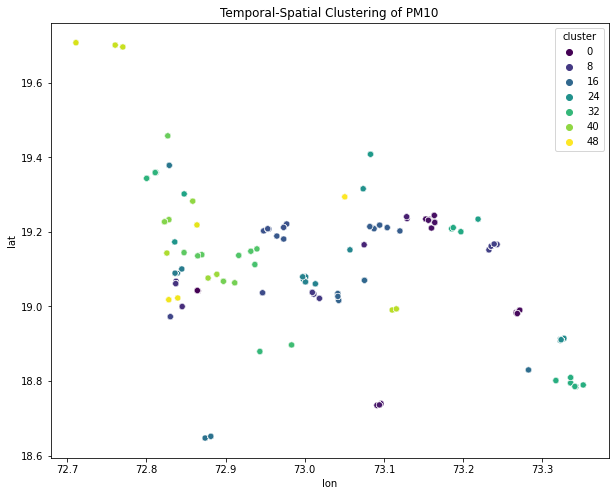

In [16]:
from sklearn.cluster import DBSCAN

# Prepare data for clustering
coords = data_2[['lat', 'lon']].values
db = DBSCAN(eps=0.02, min_samples=5).fit(coords)
data_2['cluster'] = db.labels_

# Plot clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='lon', y='lat', hue='cluster', data=data_2, palette='viridis')
plt.title('Temporal-Spatial Clustering of PM10')
plt.show()

In [19]:
from sklearn.cluster import DBSCAN

# Adjust DBSCAN parameters
eps = 0.05  # Optimise this to see how numbers changes. -1 (noise point) should have least count of clusters.
min_samples = 5  # Decrease this value to form clusters with fewer points

# Perform DBSCAN clustering
coords = data_2[['lat', 'lon']].values
db = DBSCAN(eps=eps, min_samples=min_samples).fit(coords)
data_2['cluster'] = db.labels_

# Count the number of points in each cluster
cluster_counts = data_2['cluster'].value_counts().sort_index()
print(cluster_counts)

0     768
1      96
2     456
3      72
4     288
5      96
6     168
7      48
8     120
9     120
10     48
11     24
12     48
13     48
14     24
15     72
16     48
17     48
18     24
Name: cluster, dtype: int64
